In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import librosa

from transformers import AutoFeatureExtractor, AutoModel, HubertForSequenceClassification
from datasets import load_dataset

## Testing

In [ ]:
dataset = load_dataset("hf-internal-testing/librispeech_asr_demo", "clean", split="validation", trust_remote_code=True)
dataset = dataset.sort("id")
sampling_rate = dataset.features["audio"].sampling_rate

In [ ]:
dataset[0]['audio']['array'].shape, sampling_rate

((93680,), 16000)

In [ ]:
feature_extractor = AutoFeatureExtractor.from_pretrained("superb/hubert-base-superb-ks")
model = HubertForSequenceClassification.from_pretrained("superb/hubert-base-superb-ks")

# audio file is decoded on the fly
inputs = feature_extractor(dataset[0]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_ids = torch.argmax(logits, dim=-1).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

'_unknown_'

In [ ]:
from transformers import AutoProcessor, AutoModel

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
model = AutoModel.from_pretrained("facebook/hubert-base-ls960")
model

HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Para

In [ ]:

# compute loss - target_label is e.g. "down"
target_label = model.config.id2label[0]
inputs["labels"] = torch.tensor([model.config.label2id[target_label]])
loss = model(**inputs).loss
round(loss.item(), 2)

In [ ]:
inputs = feature_extractor(dataset[5]["audio"]["array"], sampling_rate=sampling_rate, return_tensors="pt")
y = model(**inputs)

In [ ]:
y.last_hidden_state.shape

torch.Size([1, 450, 768])

In [ ]:
(dataset[5]["audio"]["array"].shape[0] - 400) // 320 + 1

450

In [34]:
import torch
import torch.nn as nn

class CNNDiarizationModel(nn.Module):
    def __init__(self, input_dim, num_filters, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim,
                               out_channels=num_filters,
                               kernel_size=kernel_size,
                               stride=1,
                               padding='same')
        self.conv2 = nn.Conv1d(in_channels=num_filters,
                               out_channels=num_filters,
                               kernel_size=kernel_size,
                               stride=1,
                               padding='same')
        self.fc = nn.Linear(num_filters, 3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, sequence_length, input_dim)
        x = x.transpose(1, 2)  # (batch_size, input_dim, sequence_length)
        x = torch.relu(self.conv1(x))  # Apply first convolution
        print(x.shape)
        x = torch.relu(self.conv2(x))  # Apply second convolution
        print(x.shape)
        x = x.transpose(1, 2)  # Back to (batch_size, sequence_length, num_filters)
        x = self.fc(x)  # Linear layer for frame-wise classification
        x = self.sigmoid(x)  # Sigmoid activation for binary output
        return x

y = torch.tensor(np.random.randn(1, 450, 768), dtype=torch.float32)
s2s = CNNDiarizationModel(768, 64, 5)
# s2s(y.last_hidden_state).shape
s2s(y).shape

torch.Size([1, 64, 450])
torch.Size([1, 64, 450])


torch.Size([1, 450, 3])

## CNN Decoder

In [10]:
N_MFCC = 13
FRAMESIZE = 0.025
FRAMESHIFT = 0.020
N_MELS = 40
RATE = 16000
WIN_LENGTH = int(RATE * FRAMESIZE)
HOP_LENGTH = int(RATE * FRAMESHIFT)

In [4]:
def remove_silent(sig, threshold=20):
    nonsilent_bounds = librosa.effects.split(sig, top_db=threshold, frame_length=WIN_LENGTH, hop_length=HOP_LENGTH)
    nonsilent_sig = np.concatenate([sig[start:end] for start, end in nonsilent_bounds])
    return nonsilent_sig

In [113]:
def cmvn(mfcc, mean_normalize=True, var_normalize=True):
    mean = np.mean(mfcc, axis=1, keepdims=True)
    var = np.var(mfcc, axis=1, keepdims=True)

    mfcc_normalized = mfcc.copy()
    if mean_normalize: mfcc_normalized -= mean
    if var_normalize: mfcc_normalized /= np.sqrt(var)
    return mfcc_normalized

In [115]:
def extract_mfcc(sig):
    # nonsilent_sig = remove_silent(sig)
    mfcc = librosa.feature.mfcc(
        y=sig, 
        sr=RATE, 
        n_mfcc=N_MFCC, 
        n_fft=WIN_LENGTH, 
        win_length=WIN_LENGTH,
        hop_length=HOP_LENGTH, 
        n_mels=N_MELS, 
        window=np.hanning
    )
    velocity = librosa.feature.delta(mfcc)
    acceleration = librosa.feature.delta(mfcc, order=2)
    features = np.concatenate([mfcc, velocity, acceleration], axis=0)
    return cmvn(features)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
hubert = AutoModel.from_pretrained("facebook/hubert-base-ls960").to(device)
hubert.eval()

cuda


HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Para

In [212]:
# hubert()
inputs = feature_extractor(np.random.randn(50000), sampling_rate=RATE, return_tensors="pt")
y = hubert(**inputs).last_hidden_state.transpose(1, 2).squeeze()
y.shape, y.dtype
# extract_mfcc(np.random.randn(50000)).shape

(torch.Size([768, 156]), torch.float32)

In [174]:
train_indices = np.random.choice(len(signals), size=int(0.8*len(signals)), replace=False)
test_indices = np.array([i for i in range(len(signals)) if i not in train_indices])
np.save("train_indices_full.npy", train_indices)
np.save("test_indices_full.npy", test_indices)

In [13]:
signals = np.load('VAD_signals_full.npy')
labels = np.load('VAD_labels_full.npy')
lengths = np.load('VAD_frame_lengths.npy')
train_indices = np.load('train_indices_full.npy')
test_indices = np.load('test_indices_full.npy')
signals.shape, labels.shape, lengths.shape, train_indices.shape, test_indices.shape

((119, 692171), (119, 2162), (119,), (95,), (24,))

In [120]:
mfcc_features = []
for signal in tqdm(signals):
    features = extract_mfcc(signal)[:, 1:-1]
    features = torch.tensor(features, dtype=torch.float32)
    mfcc_features.append(features)
mfcc_features = np.array(mfcc_features, dtype=object)

100%|██████████| 119/119 [00:03<00:00, 34.23it/s]
C:\Users\somas\AppData\Local\Temp\ipykernel_6360\3079998636.py:6: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  mfcc_features = np.array(mfcc_features, dtype=object)


In [16]:
hubert_features = []
for signal in tqdm(signals):
    features = feature_extractor(signal, sampling_rate=RATE, return_tensors="pt").to(device)
    features = hubert(**features).last_hidden_state.detach().cpu().transpose(1, 2).squeeze()
    hubert_features.append(features)

100%|██████████| 119/119 [00:32<00:00,  3.70it/s]


In [25]:
with open('hubert_features_full.pkl', 'wb') as f:
    pickle.dump(hubert_features, f)

In [11]:
with open('hubert_features_full.pkl', 'rb') as f:
    hubert_features = pickle.load(f)
    hubert_features = np.array(hubert_features, dtype=object)

C:\Users\somas\AppData\Local\Temp\ipykernel_19672\3088725779.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  hubert_features = np.array(hubert_features, dtype=object)


In [14]:
NUM_EPOCHS = 100
LEARNING_RATE = 1e-5
BATCH_SIZE = 4
NUM_FILTERS = [128, 256]
KERNEL_SIZE = 5
FEATURES = 'hubert'

In [215]:
class MFCCDataset:

    def __init__(self, features, labels, lengths):
        self.features = features
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        length = self.lengths[idx]
        # features = extract_mfcc(signal)[:, 1:-1]
        return feature, torch.tensor(label), length

train_dataset = MFCCDataset(mfcc_features[train_indices], labels[train_indices], lengths[train_indices])
test_dataset = MFCCDataset(mfcc_features[test_indices], labels[test_indices], lengths[test_indices])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
class HuBERTDataset(Dataset):

    def __init__(self, features, labels, lengths):
        self.features = features
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        length = self.lengths[idx]
        # features = feature_extractor(signal, sampling_rate=RATE, return_tensors="pt").to(device)
        # features = hubert(**features).last_hidden_state.detach().cpu().transpose(1, 2).squeeze()
        return feature, torch.tensor(label), length
    
train_dataset = HuBERTDataset(hubert_features[train_indices], labels[train_indices], lengths[train_indices])
test_dataset = HuBERTDataset(hubert_features[test_indices], labels[test_indices], lengths[test_indices])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [167]:
for x, y, z in train_loader:
    print(x.shape, y.shape, z.shape)
    break

torch.Size([4, 768, 2162]) torch.Size([4, 2162]) torch.Size([4])


In [7]:
class CNNDiarizationModel(nn.Module):

    def __init__(self, input_dim, num_filters, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim,
                               out_channels=num_filters[0],
                               kernel_size=kernel_size,
                               stride=1,
                               padding='same')
        self.conv2 = nn.Conv1d(in_channels=num_filters[0],
                               out_channels=num_filters[1],
                               kernel_size=kernel_size,
                               stride=1,
                               padding='same')
        self.fc = nn.Linear(num_filters[1], 3)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (batch_size, sequence_length, input_dim)
        # x = x.transpose(1, 2)  # (batch_size, input_dim, sequence_length)
        x = torch.relu(self.conv1(x))  # Apply first convolution
        x = torch.relu(self.conv2(x))  # Apply second convolution
        x = x.transpose(1, 2)  # Back to (batch_size, sequence_length, num_filters)
        x = self.fc(x)  # Linear layer for frame-wise classification
        # x = self.sigmoid(x)  # Sigmoid activation for binary output
        return x

In [84]:
def compute_accuracy(trues, preds):
    correct = sum([1 for t, p in zip(trues, preds) if t == p])
    return correct / len(trues)

In [185]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = CNNDiarizationModel(x.shape[1], NUM_FILTERS, KERNEL_SIZE).to(device)
model.train()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_losses, test_losses, silent_accuracies, nonsilent_accuracies = [], [], [], []

for epoch in (pbar := tqdm(range(NUM_EPOCHS))):
    
    epoch_loss = 0.0
    for signal, label, length in train_loader:

        signal = signal.to(device)
        label = label.to(device)
        length = length.cpu().numpy()
        output = model(signal)
        
        optimizer.zero_grad()
        loss = criterion(output.view(-1, output.size(-1)), label.view(-1))
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))

    if (epoch + 1) % 5 == 0:
        model.eval()
        preds, trues = [], []
        nonsilent_preds, nonsilent_trues = [], []

        eval_loss = 0.0
        for signal, label, length in test_loader:
            signal = signal.to(device)
            label = label.to(device)
            length = length.cpu().numpy()
            output = model(signal)

            preds.extend(list(output.view(-1, output.size(-1)).argmax(-1).cpu().detach().numpy()))
            trues.extend(list(label.view(-1).cpu().detach().numpy()))

            for b in range(length.shape[0]):
                nonsilent_preds.extend(list(output[b, :length[b]].argmax(-1).cpu().detach().numpy()))
                nonsilent_trues.extend(list(label[b, :length[b]].cpu().detach().numpy()))

            loss = criterion(output.view(-1, output.size(-1)), label.view(-1))
            eval_loss += loss.item()
        test_losses.append(eval_loss / len(test_loader))

        # nonsilent_trues, nonsilent_preds = [], []
        # for t, p in zip(trues, preds):
        #     if t != 2:
        #         nonsilent_trues.append(t)
        #         nonsilent_preds.append(p)

        silent_accuracies.append(compute_accuracy(trues, preds))
        nonsilent_accuracies.append(compute_accuracy(nonsilent_trues,  nonsilent_preds))
        if nonsilent_accuracies[-1] >= np.max(nonsilent_accuracies):
            torch.save(model, f'chks/{FEATURES}_best_{NUM_FILTERS[0]}_{NUM_FILTERS[1]}_{KERNEL_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}_full.pt')
        model.train()

    if len(test_losses): pbar.set_description(f'Training Loss: {train_losses[-1]:.3f} | Test Loss: {test_losses[-1]:.3f} | Accuracy: {nonsilent_accuracies[-1]:.3f}')
    else: pbar.set_description(f'Training Loss: {train_losses[-1]:.3f}')

torch.save(model, f'chks/{FEATURES}_final_{NUM_FILTERS[0]}_{NUM_FILTERS[1]}_{KERNEL_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}_full.pt')

cuda


Training Loss: 0.128 | Test Loss: 0.136 | Accuracy: 0.785: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


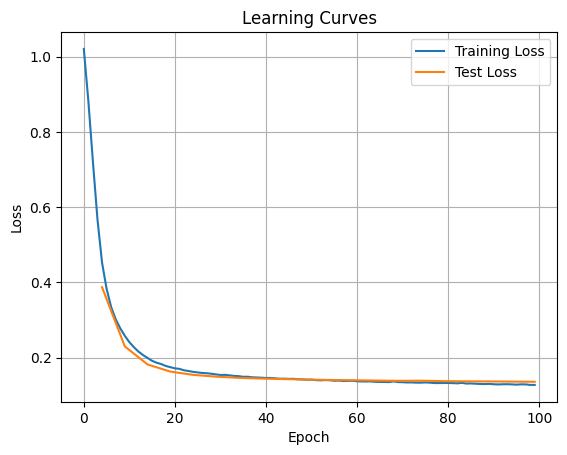

In [186]:
plt.plot(range(NUM_EPOCHS), train_losses, label='Training Loss')
plt.plot(range(4, NUM_EPOCHS, 5), test_losses, label='Test Loss')
# plt.plot(range(4, NUM_EPOCHS, 5), nonsilent_accuracies, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.grid()
plt.legend()
plt.savefig(f'plots/{FEATURES}_loss_{NUM_FILTERS[0]}_{NUM_FILTERS[1]}_{KERNEL_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.png')
plt.show()

In [187]:
logs = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'silent_accuracies': silent_accuracies,
    'nonsilent_accuracies': nonsilent_accuracies
}
with open(f'logs/{FEATURES}_logs_{NUM_FILTERS[0]}_{NUM_FILTERS[1]}_{KERNEL_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.pkl', 'wb') as f:
    pickle.dump(logs, f)

In [188]:
np.max(silent_accuracies), np.max(nonsilent_accuracies)

(0.9307354301572618, 0.7854712588790067)

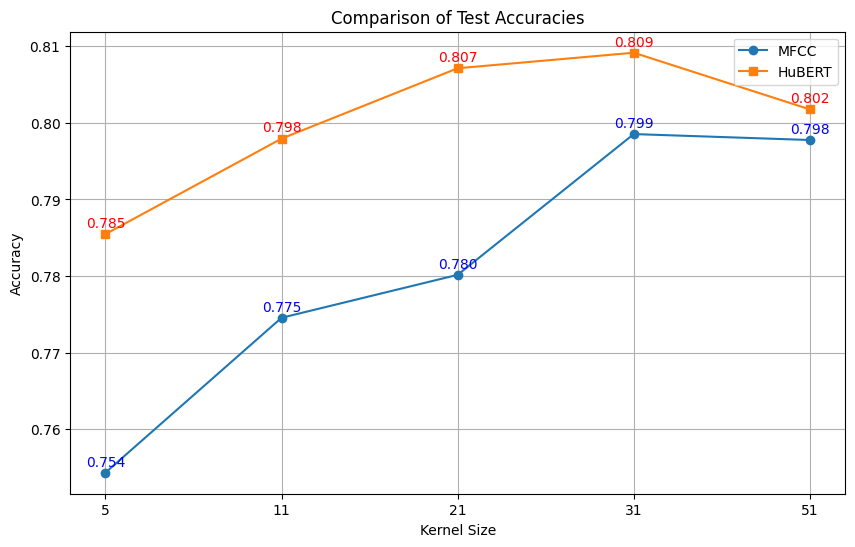

In [197]:
import matplotlib.pyplot as plt
import numpy as np

# Data
k_values = [5, 11, 21, 31, 51]
uniform_k_positions = np.arange(len(k_values))  # [0, 1, 2, 3, 4]
array_1 = [0.7854712588790067, 0.7979466364233272, 0.807139019877037, 0.8091685071330508, 0.8017668477287649]
array_2 = [0.7543126604190294, 0.7745478421775205, 0.7801587775323823, 0.7985435444398018, 0.7977675640183848]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(uniform_k_positions, array_2, marker='o', label='MFCC')
plt.plot(uniform_k_positions, array_1, marker='s', label='HuBERT')

# Label each point on the lines
for i, pos in enumerate(uniform_k_positions):
    plt.text(pos, array_2[i] + 0.0005, f'{array_2[i]:.3f}', ha='center', va='bottom', color='blue')  # Offset above array_2
    plt.text(pos, array_1[i] + 0.0005, f'{array_1[i]:.3f}', ha='center', va='bottom', color='red')   # Offset above array_1

# Adding labels and title
plt.title('Comparison of Test Accuracies')
plt.xlabel('Kernel Size')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Set custom x-ticks with k_values
plt.xticks(uniform_k_positions, k_values)  # Label the uniform positions with k_values
plt.savefig('test_accuracies_ks.png')
# Show plot
plt.show()


In [171]:
model.eval()
preds, trues = [], []

eval_loss = 0.0
for signal, label in test_loader:
    signal = signal.to(device)
    label = label.to(device)
    output = model(signal)
    # print(output.view(-1, 3).argmax(-1).shape, label.view(-1).shape)

    preds.extend(list(output.view(-1, output.size(-1)).argmax(-1).cpu().detach().numpy()))
    trues.extend(list(label.view(-1).cpu().detach().numpy()))

    loss = criterion(output.view(-1, output.size(-1)), label.view(-1))
    eval_loss += loss.item()
eval_loss / len(test_loader)

0.9768754442532858

In [172]:
nonsilent_trues, nonsilent_preds = [], []
for t, p in zip(trues, preds):
    if t != 2:
        nonsilent_trues.append(t)
        nonsilent_preds.append(p)

print(compute_accuracy(trues, preds))
print(compute_accuracy(nonsilent_trues,  nonsilent_preds))

0.8518627533428643
0.7267351384998444


In [ ]:
torch.save(model, f'chks/mfcc_model_{NUM_FILTERS[0]}_{NUM_FILTERS[1]}_{KERNEL_SIZE}_{NUM_EPOCHS}_{LEARNING_RATE}_{BATCH_SIZE}.pt')

In [101]:
outputs = torch.FloatTensor([[[0.5, 0.5, 1.5], [0.2, 0.8, 0.0]], [[0.9, 0.1, 0.0], [0.3, 0.3, 4.4]]])
labels = torch.LongTensor([[2, 1], [0, 2]])
outputs.view(-1, outputs.size(-1)), labels.view(-1)

(tensor([[0.5000, 0.5000, 1.5000],
         [0.2000, 0.8000, 0.0000],
         [0.9000, 0.1000, 0.0000],
         [0.3000, 0.3000, 4.4000]]),
 tensor([2, 1, 0, 2]))

In [102]:
# print(nn.CrossEntropyLoss()(torch.FloatTensor([[0.5, 0.5, 0.5]]), torch.FloatTensor([[1, 0, 1]])))
print(nn.CrossEntropyLoss()(torch.FloatTensor([[0.5, 0.5, 0.5]]), torch.LongTensor([1])))
print(nn.CrossEntropyLoss()(torch.FloatTensor([[0.2, 0.2, 0.2]]), torch.LongTensor([1])))
print(nn.CrossEntropyLoss()(torch.FloatTensor([[0.5, 0.5, 1.5], [0.2, 0.8, 0.0]]), torch.LongTensor([2, 1])))
print(nn.CrossEntropyLoss()(outputs.view(-1, outputs.size(-1)), labels.view(-1)))

tensor(1.0986)
tensor(1.0986)
tensor(0.6218)
tensor(0.4737)


## Plotting

In [8]:
mfcc_cnn = torch.load('chks/mfcc_best_128_256_21_200_1e-05_4_full.pt', weights_only=False)
hubert_cnn = torch.load('chks/hubert_best_128_256_21_100_1e-05_4_full.pt', weights_only=False)
model = mfcc_cnn.cpu()
# model = hubert_cnn.cpu()

In [217]:
def plot_segments(signal, label, crop, title, ax):

    points = np.linspace(0, len(signal), len(label) + 1).astype(int)
    points[-1] = len(signal)
    time_map = np.zeros_like(signal)
    for i in range(len(label)):
        time_map[points[i]:points[i+1]] = label[i]

    hindi, english, silent = signal.copy(), signal.copy(), signal.copy()
    hindi[time_map != 0] = np.nan
    english[time_map != 1] = np.nan
    silent[time_map != 2] = np.nan
    ax.plot(hindi[:crop], label='Hindi')
    ax.plot(english[:crop], label='English')
    ax.plot(silent[:crop], label='Silent', c='gray')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.grid()
    # ax.legend(loc=(1.04, 1.05))
    return ax

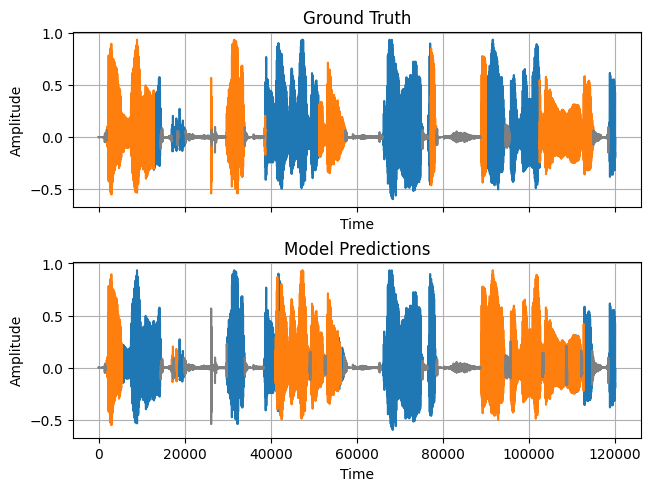

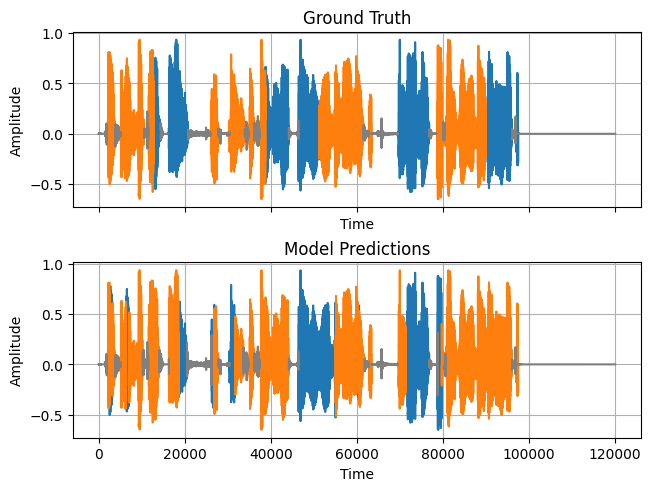

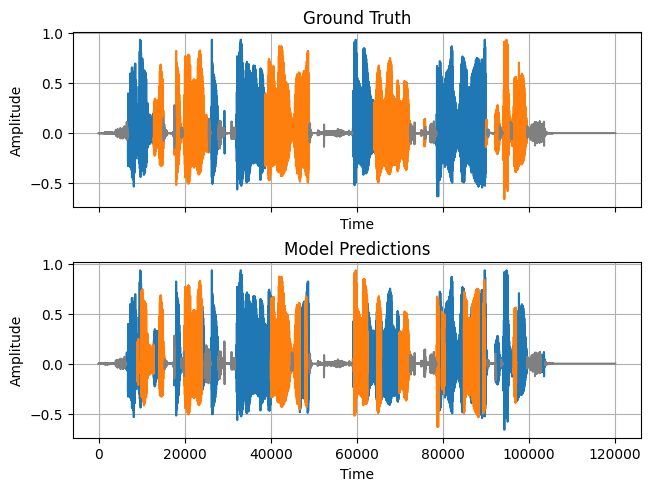

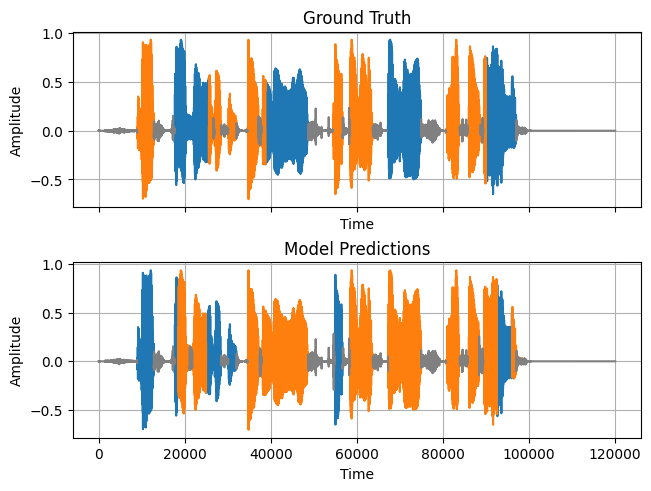

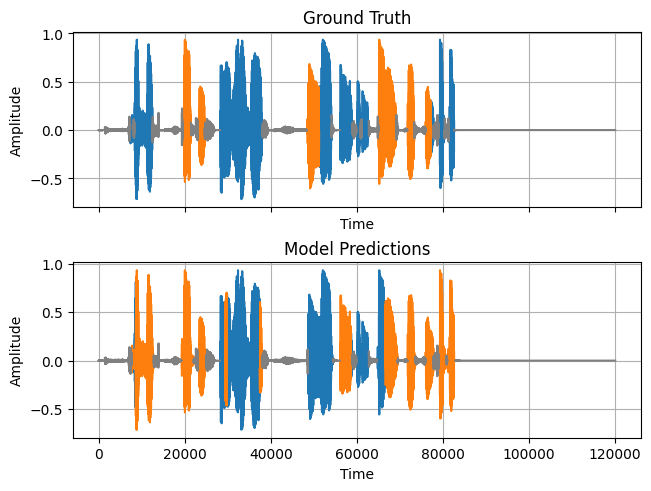

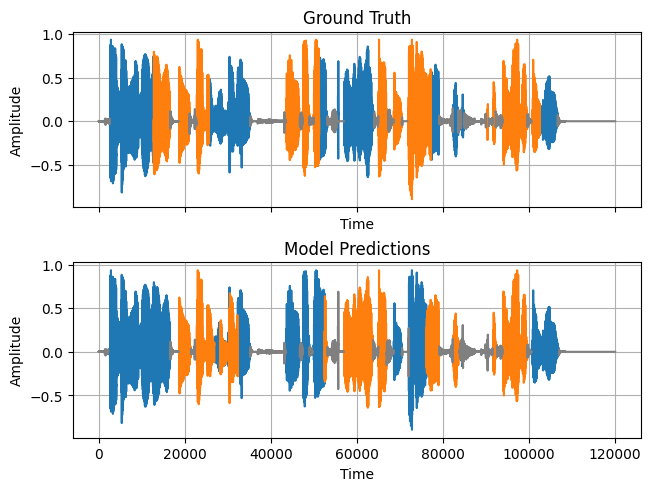

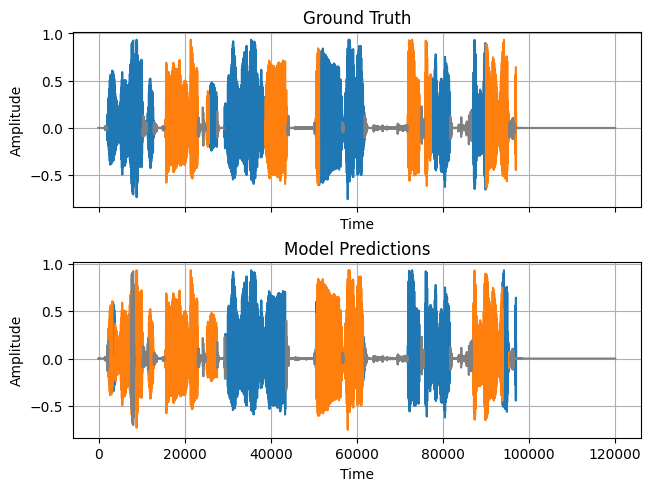

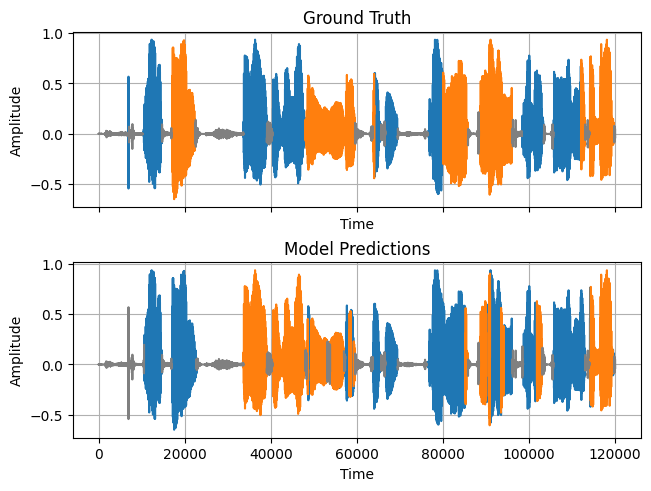

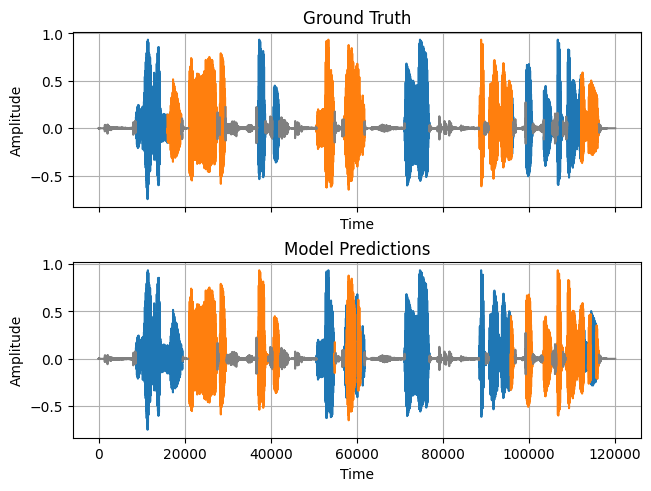

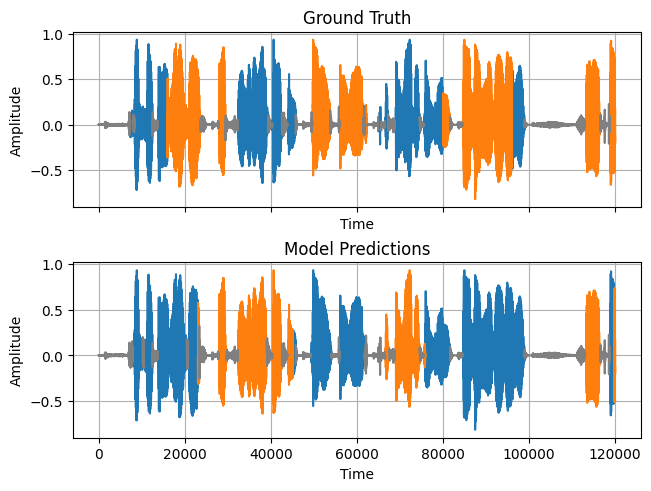

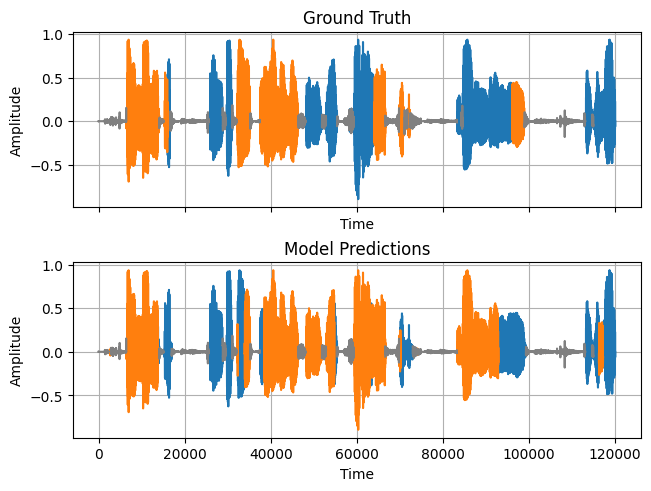

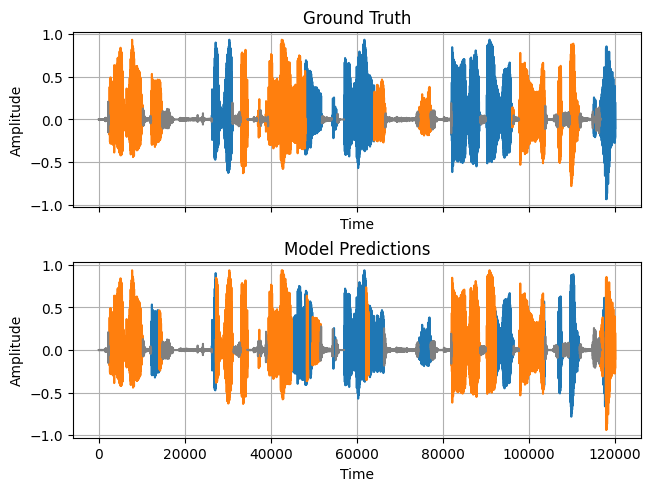

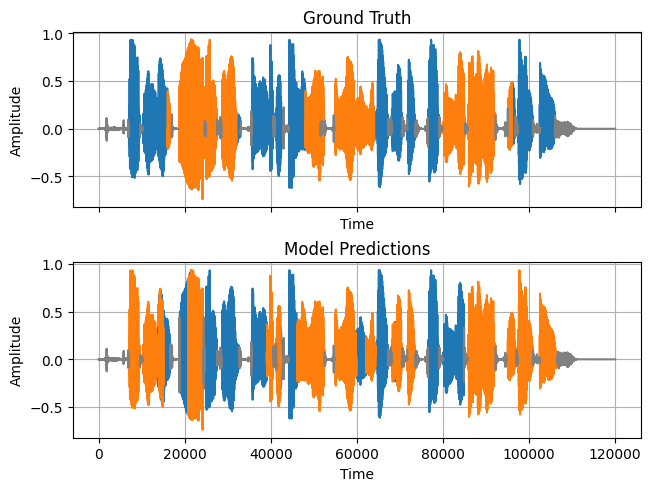

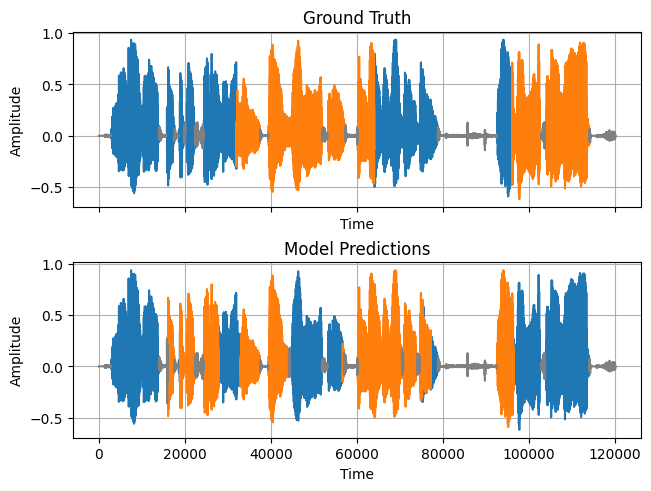

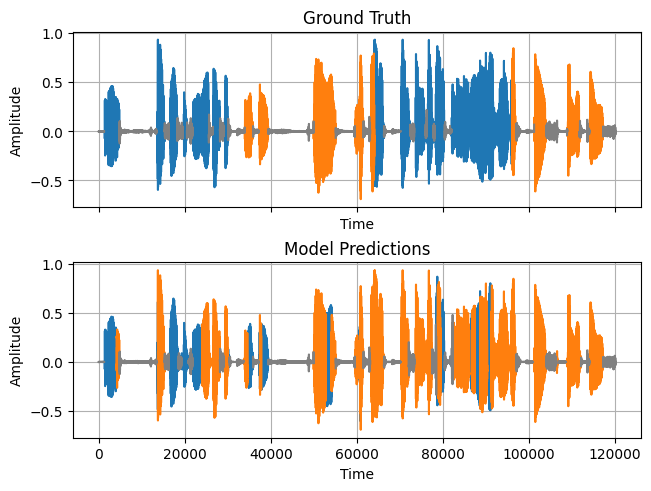

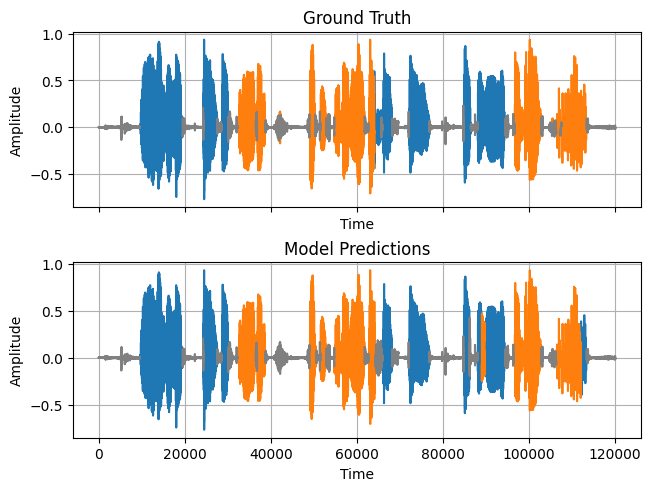

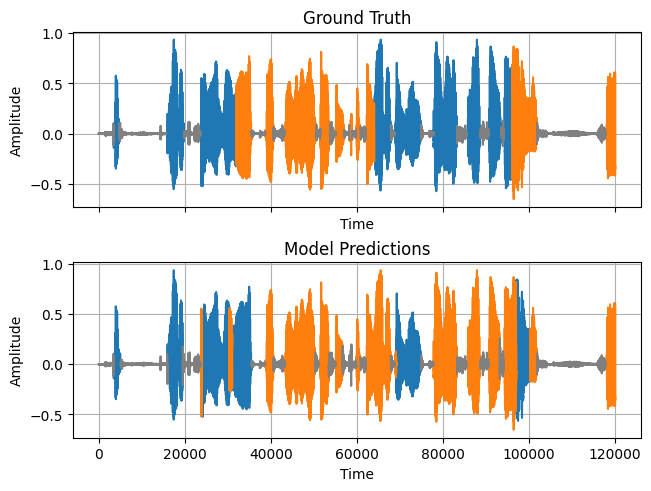

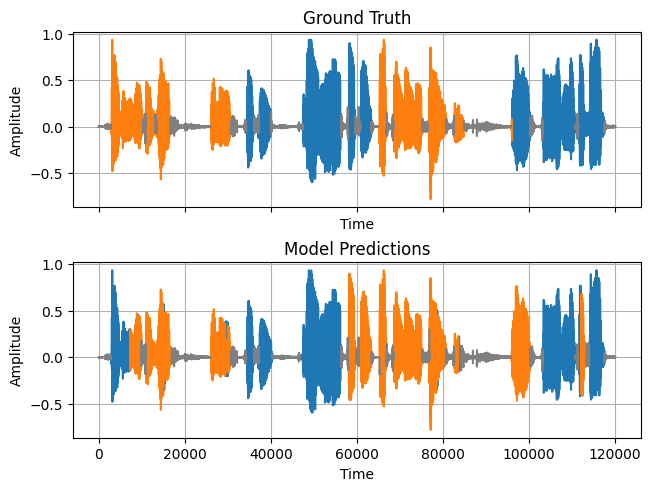

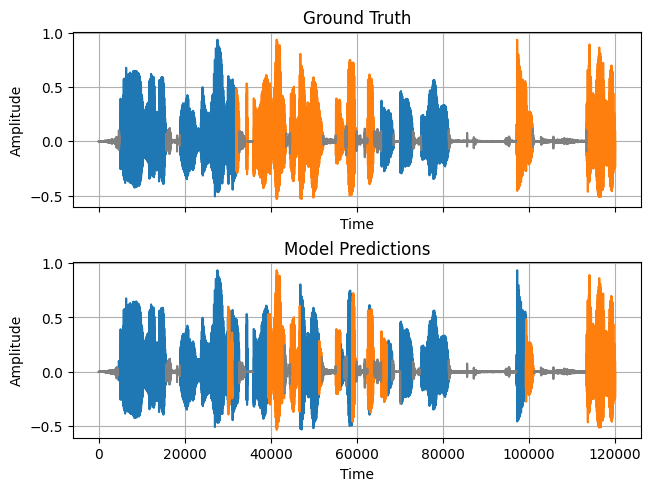

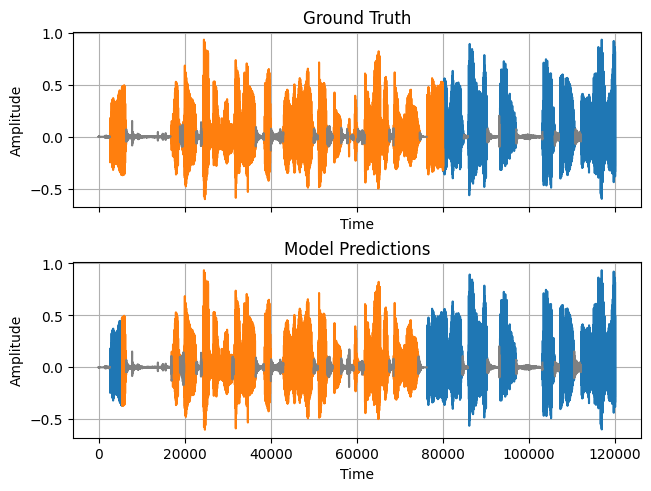

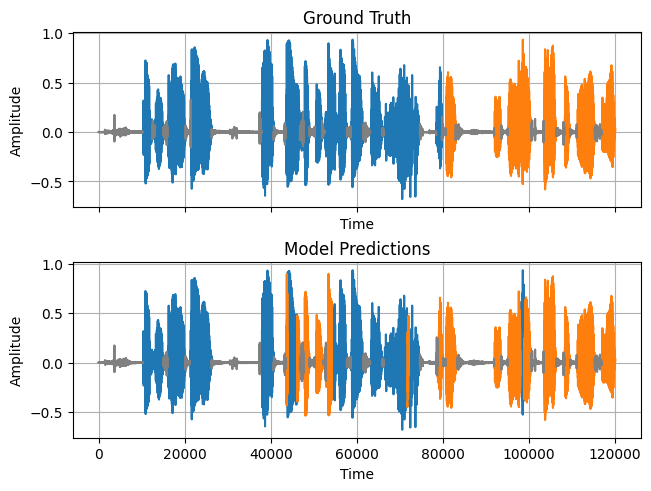

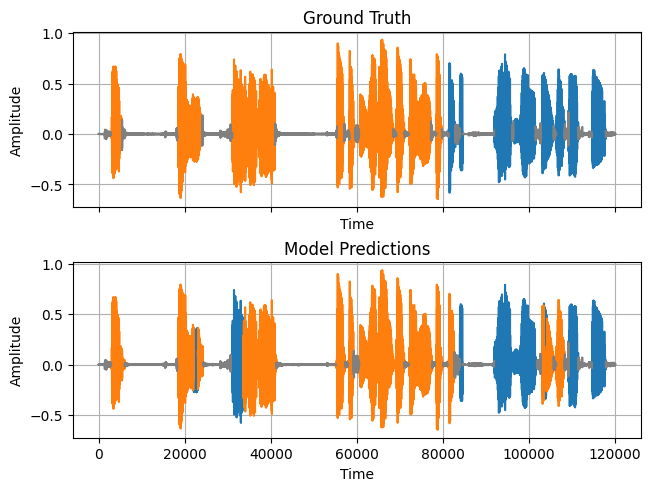

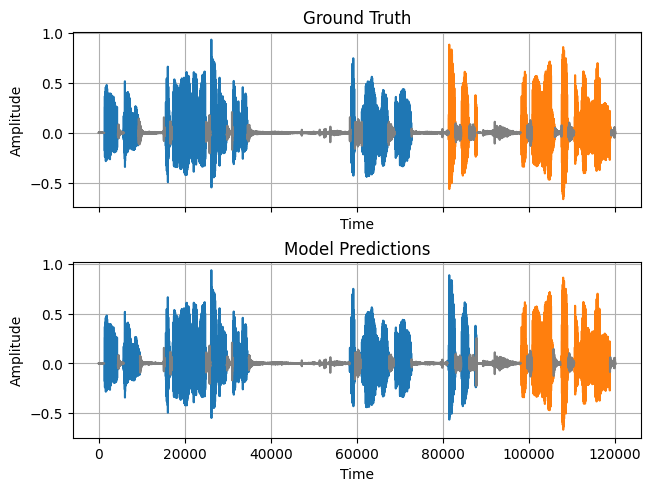

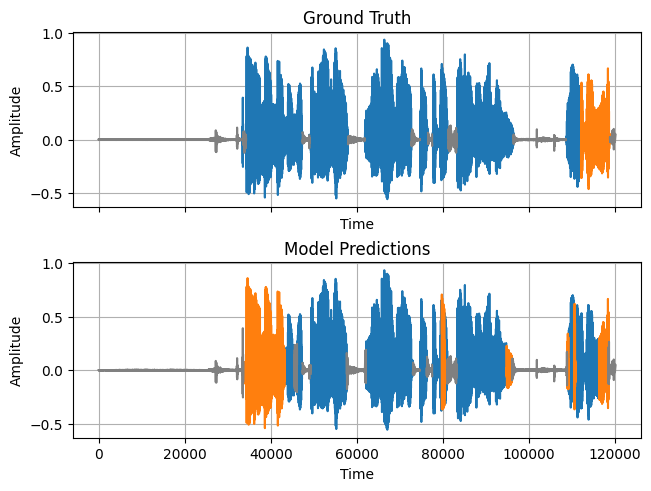

In [218]:
device = 'cpu'
for i, (signal, label, length) in enumerate(test_loader):
    
    signal = signal.to(device)
    label = label.to(device)
    length = length.cpu().numpy()
    output = model(signal)

    # preds.extend(list(output.view(-1, output.size(-1)).argmax(-1).cpu().detach().numpy()))
    # trues.extend(list(label.view(-1).cpu().detach().numpy()))
    for b in range(BATCH_SIZE):
        pred = output.detach().argmax(-1).numpy()[b]
        true = label[b].detach().numpy()
        # plt.plot(pred[:500])
        # plt.plot(true[:500])
        fig, axs = plt.subplots(2, 1, layout='constrained', sharex=True)
        plot_segments(signals[test_indices[i*BATCH_SIZE+b]], true, 120000, 'Ground Truth', axs[0])
        plot_segments(signals[test_indices[i*BATCH_SIZE+b]], pred, 120000, 'Model Predictions', axs[1])
        plt.show()
    
    if i > 5:
        break

In [62]:
model = hubert_cnn.cpu()
embeddings = []
def hook_fn(module, input, output):
    embeddings.append(output.detach().cpu())

layer = dict(model.named_modules())['conv2']
hook = layer.register_forward_hook(hook_fn)

In [63]:
device = 'cpu'
embeds, labels = [], []
for i, (signal, label, length) in enumerate(test_loader):
    
    signal = signal.to(device)
    label = label.to(device)
    length = length.cpu().numpy()
    output = model(signal)
    print(len(embeddings))

    # embeds.extend(list(output.view(-1, output.size(-1)).argmax(-1).cpu().detach().numpy()))
    labels.append(label)
hook.remove()
    

6
12
18
24
30
36


In [54]:
embeddings = torch.cat(embeddings, dim=0).numpy()
labels = torch.cat(labels, dim=0).numpy()

In [57]:
embeddings.shape, labels.shape

((144, 256, 2162), (24, 2162))

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)
# pca = PCA(n_components=2)
# embeddings_2d = pca.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(10, 8))
for label in range(3):
    idx = labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f'Class {label}', alpha=0.6)

plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend()
plt.show()